In [1]:
import pickle

fname = '../../data/fmri-FC-slim.pkl'
fmriDict = None

with open(fname, 'rb') as f:
    fmriDict = pickle.load(f)
    
print(fmriDict.keys())

dict_keys(['FC-slim', 'subjNum2IdxMap', 'subjIdx2NumMap', 'groupsNormalDiagMap'])


In [2]:
def getGroupIdcs(groupsMap):
    normals = []
    fibros = []
    for num,diag in groupsMap.items():
        if diag == 1:
            normals.append(num)
        else:
            fibros.append(num)
    return normals,fibros

normals, fibros = getGroupIdcs(fmriDict['groupsNormalDiagMap'])

print(len(normals))
print(normals)
print(len(fibros))
print(fibros)

33
['007', '012', '014', '016', '018', '021', '022', '026', '030', '031', '032', '033', '034', '036', '042', '045', '047', '056', '058', '059', '060', '061', '064', '066', '068', '069', '070', '072', '073', '074', '075', '076', '077']
33
['002', '004', '005', '006', '008', '009', '010', '011', '013', '015', '017', '019', '020', '023', '024', '025', '028', '029', '037', '038', '039', '040', '043', '044', '046', '049', '050', '052', '053', '054', '055', '062', '063']


In [3]:
# Get response variables

def numInt2Str(num):
    num = int(num)
    return f'00{num}' if num < 10 else f'0{num}'

response = None

with open('../../data/fmri-clinical.pkl', 'rb') as f:
    response = pickle.load(f)
    
print(numInt2Str(response[0,4]))

007


In [4]:
import numpy as np

def getVar(num, normals, fibros, response, varIdx):
    num = numInt2Str(num)
    if num in normals or num in fibros:
        idx = np.where(int(num) == response[0])
        return float(response[varIdx,idx])
    raise Exception('num not in normal or fibros')

print([getVar(num, normals, fibros, response, 2) for num in normals])
print([getVar(num, normals, fibros, response, 2) for num in fibros])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 17.0, 0.67, 2.0, 7.0, 4.0, 2.0, 7.0, 6.0, 4.0, 0.16, 2.0, 6.0, 2.0, 0.4, 2.0, 15.0, 1.0, 0.5, 8.0, 6.0, 1.0, 0.66, 0.5, 0.33, 2.5, 4.0, 1.5, 9.0, 2.0, 20.0, 0.12, 7.0]


In [114]:
import numpy as np

a, b = np.triu_indices(264, 1)

def idxFromRegs(regs, a, b):
    ai,bi = [int(reg) for reg in regs.split('-')]
    idx = np.where(np.logical_and(ai == a,bi == b))
    return idx[0][0]

# print(idxFromRegs('262-263',a,b).shape)
connWmultFCDiff = []
connWmultFC = []

with open('../../data/fmri-regions/connWmultFCdiff.txt', 'r') as f:
    for line in f.readlines():
        connWmultFC.append(idxFromRegs(line, a, b))

connWmultFC = np.array(connWmultFC)
print(connWmultFC)

[21516   789 21527 20858   960 25319  3000 33895  6471   899 30946  8883
  3652   803  3601 29919   393 21273 15009 18526]


In [115]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

def arith(n):
    return int(n*(n+1)/2)

def getAvg(res):
    nPara = len(res)
    avg = 0
    for para in range(nPara):
        avg += res[para]/nPara
    return avg

class LatSim(nn.Module):
    def __init__(self, inp, dp=0.5, edp=0, wInit=1e-4, temp=1):
        super(LatSim, self).__init__()
        self.B = nn.Parameter(wInit*torch.randn(1,inp.shape[-1],1).float().cuda())
        self.dp = nn.Dropout(p=dp)
        self.edp = nn.Dropout(p=edp)
        self.temp = temp
        
    def getEdges(self, X, para):
        e = 1e-10
        z = X[:,para,:]@self.B[para]
        e = e+z@z.T
        return e
    
    def forward(self, x, y, testIdcs=None, temp=None):
        if temp is not None:
            self.temp = temp
        x = self.dp(x)
        res = []
        es = []
        for para in range(1):
            e = self.getEdges(x, para)
            if testIdcs is not None:
                e[:,testIdcs] = 0
            e = mask(e)
            e = self.edp(e)
            e[e == 0] = float('-inf')
            e = F.softmax(e/self.temp, dim=1)
            res.append(e@y)
            es.append(e)
        return res, es
    
def validate(model, X, y, testIdcs):
    model.eval()
    loss = None
    with torch.no_grad():
        res, _ = model(X, y, testIdcs)
        r = getAvg(res)
        if y.dim() == 1:
            loss = mseLoss(r[testIdcs], y[testIdcs]).cpu().numpy()**0.5
        else:
            corr = (torch.argmax(r, dim=1) == torch.argmax(y, dim=1))[testIdcs]
            loss = torch.sum(corr)/len(testIdcs)
    model.train()
    return loss, r

def binLoss(w):
    mag = torch.abs(w)
    maxMag = torch.max(mag, keepdim=True, dim=1).values
    p = mag/maxMag
    return -torch.sum(p*torch.log(p+1e-10))

print('Complete')

Complete


In [116]:
import sys

sys.path.append('../../src')

from imagenomer import Analysis, JsonData, JsonSubjects, JsonFCMetadata

a,b = np.triu_indices(264,1)
idcs = np.arange(34716)

labels = [f'{a[i]}-{b[i]}' for i in idcs]

print(labels[0:10])
print(labels[-10:])

import numpy as np
import random

mseLoss = nn.MSELoss()
ceLoss = nn.CrossEntropyLoss()

nRuns = 100

tot = []

nEpochs = 200
pPeriod = 5
thresh = 0.01
binParam = 0
L2 = 1e-4
DP = 0
EDP = 0
lr = 1e-4

model = f'LatentSimilarity EntropyReg={binParam} L2={L2} DP={DP} EDP={EDP} lr={lr}'
desc = 'normal(1) vs. fibromyalgia(0) rest fMRI only, model W'
analysis = Analysis(f'{desc}: {model}', 'localhost', 8000)

for run in range(nRuns):
    FCslim = fmriDict['FC-slim']
    subjNum2Idx = fmriDict['subjNum2IdxMap']

    random.shuffle(normals)
    random.shuffle(fibros)

    normalTrain = normals[:25]
    normalTest = normals[25:]

    fibrosTrain = fibros[:25]
    fibrosTest = fibros[25:]

    train = normalTrain + fibrosTrain
    test = normalTest + fibrosTest

    Xtrain = [FCslim[subjNum2Idx[num]] for num in train]
    Xtest = [FCslim[subjNum2Idx[num]] for num in test]

    Xtrain = np.stack(Xtrain)[:,connWmultFC]
    Xtest = np.stack(Xtest)[:,connWmultFC]
    
    mu_Xtrain = np.mean(Xtrain, axis=0, keepdims=True)
    sd_Xtrain = np.std(Xtrain, axis=0, keepdims=True)
    
    Xtrain = (Xtrain-mu_Xtrain)/sd_Xtrain
    Xtest = (Xtest-mu_Xtrain)/sd_Xtrain
    
    Xtrain_t = torch.from_numpy(Xtrain).unsqueeze(1).float().cuda()
    Xtest_t = torch.from_numpy(Xtest).unsqueeze(1).float().cuda()
    X_t = torch.cat([Xtrain_t, Xtest_t])
    
#     Xtrain = torch.from_numpy(Xtrain)
#     Xtest = torch.from_numpy(Xtest)
    
#     ytrain = np.array([getVar(num, normals, fibros, response, 3) for num in train])
#     ytest = np.array([getVar(num, normals, fibros, response, 3) for num in test])
    
#     ytrain_t = torch.from_numpy(ytrain).float().cuda()
#     ytest_t = torch.from_numpy(ytest).float().cuda()
    
#     print(ytrain)
#     print(ytest)

    ytrain = np.concatenate([np.ones(25), np.zeros(25)])
    ytest = np.concatenate([np.ones(8), np.zeros(8)])
    
    ytrain_t = torch.from_numpy(ytrain)
    ytest_t = torch.from_numpy(ytest)
    
    ytrain_t = torch.stack([ytrain_t, 1-ytrain_t], dim=1).float().cuda()
    ytest_t = torch.stack([ytest_t, 1-ytest_t], dim=1).float().cuda()
    
    y_t = torch.cat([ytrain_t, ytest_t])

#     print(Xtrain_t.shape)
#     print(Xtest_t.shape)
#     print(ytrain_t.shape)
#     print(ytest_t.shape)
    
    sim = LatSim(Xtrain_t, dp=DP, edp=EDP, wInit=1e-4)
    optim = torch.optim.Adam(sim.parameters(), lr=lr, weight_decay=L2)
    
    for epoch in range(nEpochs):
        optim.zero_grad()
        res, _ = sim(Xtrain_t, ytrain_t, temp=1)
        loss = []
        if ytrain_t.dim() > 1:
            loss.append(ceLoss(res[0], ytrain_t))
        else:
            loss.append(mseLoss(res[0], ytrain_t))
        loss.append(binParam*binLoss(sim.B))
        sum(loss).backward()
        optim.step()
#         if epoch % pPeriod == 0 or epoch == nEpochs-1 or all([ls < thresh for ls in loss]):
#             print(f'epoch {epoch} loss={loss}')
            
    ntr = ytrain_t.shape[0]
    ntst = ytest_t.shape[0]
    acc, r = validate(sim, X_t, y_t, np.arange(ntr,ntr+ntst))
    
    print(f'{run}. {acc}')
    
    tot.append(float(acc))
    
    w = np.sum(np.abs(sim.B[0].detach().cpu().numpy()), axis=1).astype('float64')
    wHC = np.mean(np.expand_dims(w,0)*Xtrain[:25], axis=0)
    wFM = np.mean(np.expand_dims(w,0)*Xtrain[25:], axis=0)
    w = wHC-wFM
    w = np.abs(w)
    w = w/np.max(w)
    
    jsonCompare = desc
    jsonAccuracy = float(acc)
    jsonTrain = [25,25]
    jsonTest = [8,8]
    jsonWeights = w
    jsonLabels = labels

    jsonObj = {
        'Compare': jsonCompare,
        'Model': 'Logistic Regression',
        'Accuracy': jsonAccuracy,
        'Train': jsonTrain,
        'Test': jsonTest,
        'Weights': list(jsonWeights),
        'Labels': list(connWmultFC.astype('float64')) #jsonLabels
    }
    
    dat = JsonData(analysis)
    dat.dict.update(jsonObj)
    r = dat.post()
    print(r.content)
    
#     print(r[:ntr])
#     print(r[ntr:])
    
tot = np.array(tot)
print(np.mean(tot))
print(np.std(tot))

['0-1', '0-2', '0-3', '0-4', '0-5', '0-6', '0-7', '0-8', '0-9', '0-10']
['259-260', '259-261', '259-262', '259-263', '260-261', '260-262', '260-263', '261-262', '261-263', '262-263']
0. 1.0
b'Success'
1. 0.9375
b'Success'
2. 0.875
b'Success'
3. 1.0
b'Success'
4. 1.0
b'Success'
5. 0.9375
b'Success'
6. 0.875
b'Success'
7. 0.8125
b'Success'
8. 0.9375
b'Success'
9. 0.8125
b'Success'
10. 1.0
b'Success'
11. 0.875
b'Success'
12. 0.9375
b'Success'
13. 0.9375
b'Success'
14. 1.0
b'Success'
15. 0.9375
b'Success'
16. 0.9375
b'Success'
17. 0.875
b'Success'
18. 0.875
b'Success'
19. 0.875
b'Success'
20. 0.75
b'Success'
21. 0.75
b'Success'
22. 0.8125
b'Success'
23. 0.9375
b'Success'
24. 0.75
b'Success'
25. 0.875
b'Success'
26. 0.75
b'Success'
27. 1.0
b'Success'
28. 1.0
b'Success'
29. 0.9375
b'Success'
30. 0.875
b'Success'
31. 0.9375
b'Success'
32. 0.875
b'Success'
33. 0.875
b'Success'
34. 0.9375
b'Success'
35. 0.875
b'Success'
36. 0.9375
b'Success'
37. 0.9375
b'Success'
38. 1.0
b'Success'
39. 0.875
b'

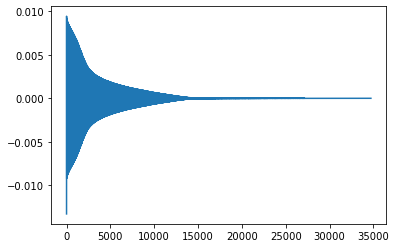

In [87]:
import matplotlib.pyplot as plt

wnp = sim.B[0].detach().cpu().numpy()
wnp0 = wnp[:,0]
# wnp1 = wnp[:,1]
idcs0 = np.argsort(np.abs(wnp0))
# idcs1 = np.argsort(np.abs(wnp1))
plt.plot(wnp0[idcs0[::-1]])
# plt.plot(wnp1[idcs1])
plt.show()

In [18]:
commNames = []
commAffil = {}
commAbrev = 'SMH,SMM,CNG,AUD,DMN,MEM,VIS,FRT,SAL,SUB,VTR,DRL,CB,UNK'.split(',')
commCount = np.zeros(14)

powerAffilFname = '../../power/power264CommunityAffiliation.1D'

with open(powerAffilFname, 'r') as f:
    for i,line in enumerate(f.readlines()):
        commAffil[i] = int(line)-1
        commCount[commAffil[i]] += 1
        
print(commAffil)
print(commCount.astype('int'))

{0: 13, 1: 13, 2: 13, 3: 13, 4: 13, 5: 13, 6: 13, 7: 13, 8: 13, 9: 13, 10: 13, 11: 13, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 2, 47: 2, 48: 2, 49: 2, 50: 2, 51: 2, 52: 2, 53: 2, 54: 2, 55: 2, 56: 2, 57: 2, 58: 2, 59: 2, 60: 3, 61: 3, 62: 3, 63: 3, 64: 3, 65: 3, 66: 3, 67: 3, 68: 3, 69: 3, 70: 3, 71: 3, 72: 3, 73: 4, 74: 4, 75: 4, 76: 4, 77: 4, 78: 4, 79: 4, 80: 4, 81: 4, 82: 4, 83: 13, 84: 13, 85: 4, 86: 4, 87: 4, 88: 4, 89: 4, 90: 4, 91: 4, 92: 4, 93: 4, 94: 4, 95: 4, 96: 4, 97: 4, 98: 4, 99: 4, 100: 4, 101: 4, 102: 4, 103: 4, 104: 4, 105: 4, 106: 4, 107: 4, 108: 4, 109: 4, 110: 4, 111: 4, 112: 4, 113: 4, 114: 4, 115: 4, 116: 4, 117: 4, 118: 4, 119: 4, 120: 4, 121: 4, 122: 4, 123: 4, 124: 4, 125: 4, 126: 4, 127: 4, 128: 4, 129: 4, 130: 4, 131: 13, 132: 5, 133: 5, 134: 5, 135: 5, 136: 4

In [19]:
jsonMeta = JsonFCMetadata(analysis)
metaDict = {
    'CommunityMap': commAffil,
    'CommunityNames': commAbrev
}
jsonMeta.update(metaDict)
r = jsonMeta.post()
print(r.content)

b'Success'


In [20]:
i

263